# Тестовое задание - интернет магазин игрушек

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Distler-Lokomotive%2C_um_1950_%28Foto_Sp%29.JPG/640px-Distler-Lokomotive%2C_um_1950_%28Foto_Sp%29.JPG "Lothar Spurzem")

Заказчик сформулировал задание следующим образом:

Задачи:

- [x] Изучить данные
- [x] Найти данные по выручке в разрезе год-месяц,  кол-ву заказов, количеству уникальных купивших пользователей.
- [x] Найти коэффициенты сезонности по месяцам
- [x] Найти тренд и его уравнение
- [x] Спрогнозировать продажи на след год (именно выручку) в разрезе год-месяц по любой методологии
- [x] Ответить на вопрос, от чего зависит товарооборот конкретного дня
- [x] Сделать предположение по возможной очистке данных и /или их особенностям

Данные в xls - данные по продажам от одного интернет-магазина детских товаров (входил в топ-3) по России.


## Загрузка и первичное ознакомление с данными

In [ ]:
# сачиваем файл с данными
! gdown 14EhvJr8Aih6FQeP2HW5iO9SjVK1NM9W_

Downloading...
From: https://drive.google.com/uc?id=14EhvJr8Aih6FQeP2HW5iO9SjVK1NM9W_
To: /content/Тест ордерс.xlsx
100% 29.0M/29.0M [00:00<00:00, 255MB/s]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (15, 5)})

In [ ]:
df = pd.read_excel('/content/Тест ордерс.xlsx')

In [ ]:
df.head()

,id_o,user_id,price,o_date
0,3529360,2838448,1223.6,01.01.2017 AD
1,3529361,2838449,1893.5,01.01.2017 AD
2,3529362,2184575,1407.0,01.01.2017 AD
3,3529366,1935335,664.3,01.01.2017 AD
4,3529372,1935335,418.6,01.01.2017 AD


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   id_o     1000000 non-null  int64  
 1   user_id  1000000 non-null  int64  
 2   price    1000000 non-null  float64
 3   o_date   1000000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.5+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_o,1000000.0,5.018018e+06,8.370579e+05,3529325.0,4313954.75,5058715.0,5689724.75,6522255.0
user_id,1000000.0,2.999608e+06,1.563605e+06,1.0,1694076.00,3298597.0,4266813.00,5468697.0
price,1000000.0,2.427456e+03,3.503878e+03,-184.8,833.00,1533.0,2694.30,540482.6


In [ ]:
# проверка на дубликаты
sum(df.duplicated())

0

**Промежуточные выводы**

В нашем распоряжении файл с миллионом записей. Пропусков данных нет, дубликатов данных нет. Описания данных у нас нет, но можно предположить, что в колонках хранится следующая информация:


*   `id_o` — идентификатор операции,
*   `user_id` — идентификатор пользователя,
*   `price` — цена (скорее всего в рублях),
*   `o_date` — дата совершения операции.

Видно, что дата совершения операции записана в формате "ДД.ММ.ГГГГ AD" (нашей эры). Для удобства дальнейшей работы дату можно будет преобразовать в формат _datetime_.


## Исследовательский анализ данных

Посмотрим на данные повнимательнее, проверим их на выбросы и проведём преобразования типов данных.

### `id_o`

In [ ]:
df.id_o.nunique()

1000000

В данной колонке скорее всего содержатся идентификаторы операций. Все идентификаторы уникальны и представляют собой целые числа. 

### `user_id`

In [ ]:
df.user_id.nunique()

568004

In [ ]:
df.user_id.value_counts().head().to_frame()

,user_id
765861,1362
39506,1242
3136639,1199
766000,1175
221047,1021


In [ ]:
users_o = df.groupby('user_id').agg({'id_o': 'count'})

In [ ]:
users_o.columns = ['n_users']

In [ ]:
sum(users_o['n_users'] > 500)

21

In [ ]:
sum(users_o['n_users'] == 1)

434381

In [ ]:
users_o.describe()

,n_users
count,568004.000000
mean,1.760551
std,6.147095
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1362.000000


В данной колонке скорее всего содержатся идентификаторы пользователей. Некоторые идентификаторы повторяются: пользователи совершают повторные покупки. Всего у нас более 500 тысяч уникальных пользователей. Несколько пользователей совершили более 1000 покупок каждый (возможно это организации). Двадцать один пользователь совершил более 500 покупок каждый. Большая часть пользователей (более 400 тысяч) совершали по одной покупке каждый.

### `price`

In [ ]:
df.price.describe().to_frame()

,price
count,1000000.000000
mean,2427.456011
std,3503.878169
min,-184.800000
25%,833.000000
50%,1533.000000
75%,2694.300000
max,540482.600000


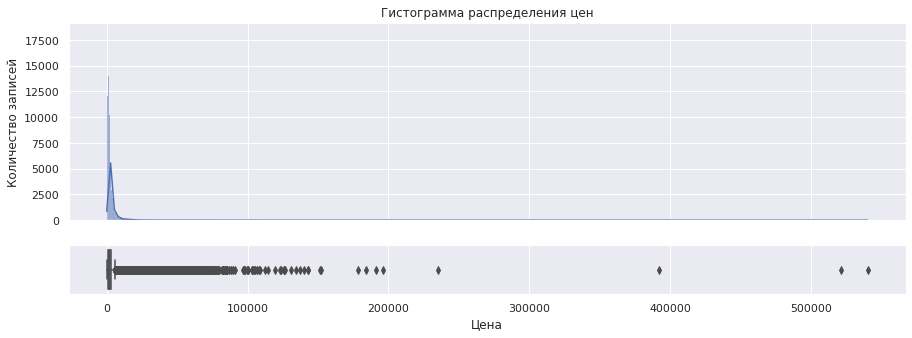

In [ ]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='price', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения цен',
     ylabel='Количество записей')
sns.boxplot(data=df, x='price', ax=axs_box)\
.set(xlabel='Цена');

Видно, что в данной колонке есть несколько записей с аномально высокими (более полумиллиона рублей) и аномально низкими (отрицательныи) ценами. Посмотрим, сколько их.

In [ ]:
df[df['price'] <= 0]['price'].count()

2

In [ ]:
df[df['price'] >= 100000]['price'].count()

34

На наше счастье в данных всего две записи с отрицательной ценой и 34 записи с ценой более ста тысяч. Можно было бы предположить, что записи с отрицательной ценой - это возврат товара, но их слишком мало, так что скорее всего это ошибочные значения. Можно предположить, что записи с аномально высокими ценами - это оптовые заказы, но их опять же слишком мало. 

Так как при построении прогнозов выбросы цен могут сильно сказаться на качестве, удалим подозрительные данные. 

In [ ]:
df = df[(df['price'] > 0) & (df['price'] < 100000)]

Посмотрим на гистограмму очищенных цен:

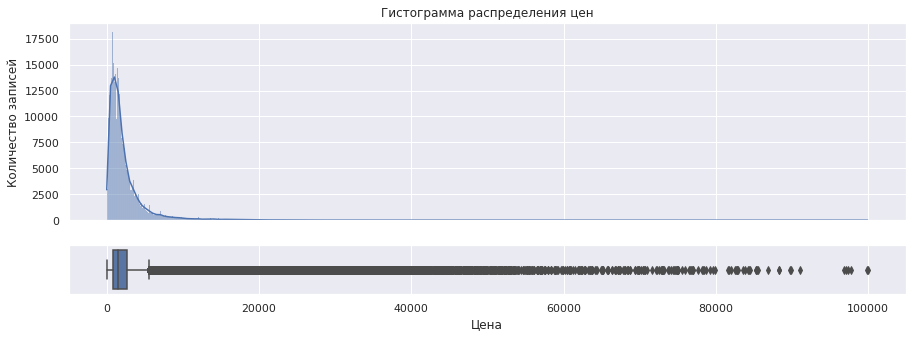

In [ ]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[4,1]))
sns.histplot(data=df, x='price', kde=True, ax=axs_hist)\
.set(title='Гистограмма распределения цен',
     ylabel='Количество записей')
sns.boxplot(data=df, x='price', ax=axs_box)\
.set(xlabel='Цена');

In [ ]:
df.price.describe()

count    999964.000000
mean       2421.954246
std        3317.011246
min           0.700000
25%         833.000000
50%        1533.000000
75%        2694.300000
max       99924.300000
Name: price, dtype: float64

Видно, что средняя цена заказа - 2421 рубля, медиана - 1533 рубля. Распределение имеет длинный правый хвост. 25 процентов заказов совершаются по цене 833 рубля и менее. 75 процентов - по цене 2694 рубля и менее. Самый крупный заказ совершён по цене почти 100 тысяч рублей, самый маленький заказ - 70 копеек. Эти цены не выглядят аномальными - большой набор "Лего" вполне может стоить и более 100 тысяч рублей, а, например, какая-то очень дешёвая пластиковая игрушка - менее рубля (при оптовом заказе и по акции).

### `o_date`

Преобразуем тип данных на более удобный для обработки.

In [ ]:
df.o_date = pd.to_datetime(df.o_date, format='%d.%m.%Y AD')

In [ ]:
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999964 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   id_o     999964 non-null  int64         
 1   user_id  999964 non-null  int64         
 2   price    999964 non-null  float64       
 3   o_date   999964 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 38.1 MB


In [ ]:
df.o_date.describe(datetime_is_numeric=True).to_frame()

,o_date
count,999964
mean,2017-07-02 10:59:42.128956160
min,2017-01-01 00:00:00
25%,2017-04-05 00:00:00
50%,2017-07-04 00:00:00
75%,2017-10-05 00:00:00
max,2017-12-07 00:00:00


В нашем файле содержатся данные о заказах с первого января 2017 года по седьмое декабря 2017 года. Данные в данной колонке выглядят нормально, каких-то подозрительных значений не видно.

**Промежуточный вывод**

В рамках исследовательского анализа данных мы установили:

* в имеющихся данных содержатся записи о 500 тысячах уникальных пользователей
* Несколько пользователей совершили более 1000 покупок каждый (возможно это организации)
* Двадцать один пользователь совершил более 500 покупок каждый. 
* Большая часть пользователей (более 400 тысяч) совершали по одной покупке каждый
* В данных обнаружились записи с подозрительно высокой ценой, но мы их отфильтровали
* Средняя цена заказа - 2421 рубля
* Медианная - 1533 рубля
* Имеются данные о заказах с первого января 2017 года по седьмое декабря 2017 года


## Анализ временного ряда

### Изменение количества заказов по времени

Посмотрим, как изменялось количество заказов по времени.

In [ ]:
o_by_date = df.groupby('o_date').agg({'id_o': 'count'})

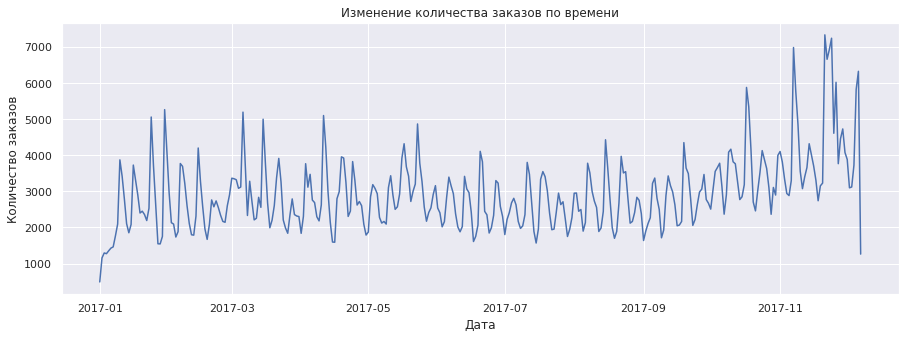

In [ ]:
sns.lineplot(data=o_by_date, legend=False)\
.set(title='Изменение количества заказов по времени',
     xlabel='Дата',
     ylabel='Количество заказов');

Видна высокая волатильность количества ежедневных заказов. Первого января заказов довольно мало (это ожидаемо, все спят после Нового года). Шестого и седьмого декабря заказов также мало, возможно данные за эти дни не полные, их лучше исключить из анализа, чтобы не искажать картину.

In [ ]:
df = df[df['o_date'] != '2017-12-06']
df = df[df['o_date'] != '2017-12-07']

In [ ]:
o_by_date = df.groupby('o_date').agg({'id_o': 'count'})

Посмотрим на график очищенных данных.

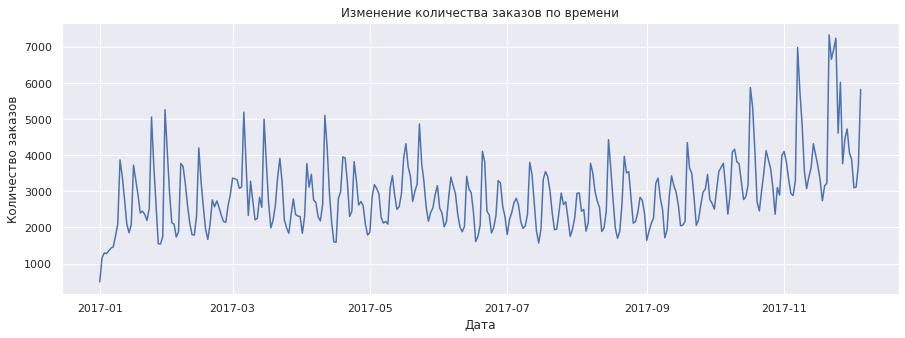

In [ ]:
sns.lineplot(data=o_by_date, legend=False)\
.set(title='Изменение количества заказов по времени',
     xlabel='Дата',
     ylabel='Количество заказов');

Красота! По данному графику пока сложно судить о каких-то закономерностях в данных, но их мы будем искать на следующих этапах.

### Изменение дневной выручки

Построим аналогичный график для выручки (просто будем суммировать цены заказов по дням).

In [ ]:
rev_by_date = df.groupby('o_date').agg({'price': 'sum'})

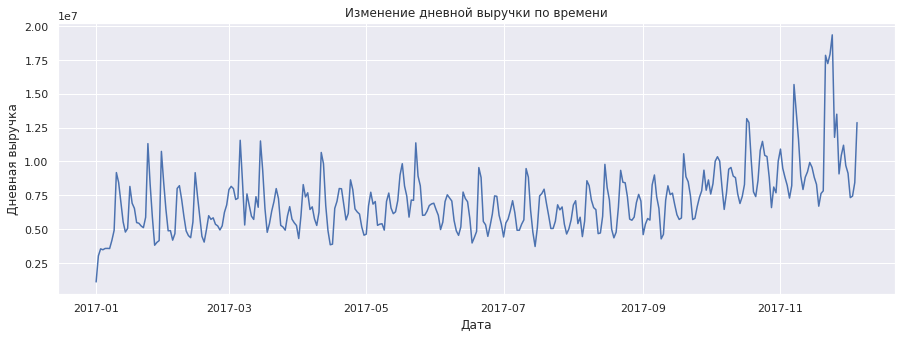

In [ ]:
sns.lineplot(data=rev_by_date, legend=False)\
.set(title='Изменение дневной выручки по времени',
     xlabel='Дата',
     ylabel='Дневная выручка');

Дневная выручка вцелом ведёт себя аналогично числу заказов (что ожидаемо). Похоже, что ближе к концу года дневная выручка начинает постепенно расти, может быть некоторые клиенты начинают загодя покупать подарки перед праздниками?

Чтобы немного сгладить график и сделать его более наглядным попробуем добавить скользящее месячное среднее.

In [ ]:
rev_by_date['mean'] = rev_by_date.rolling('30D').mean()

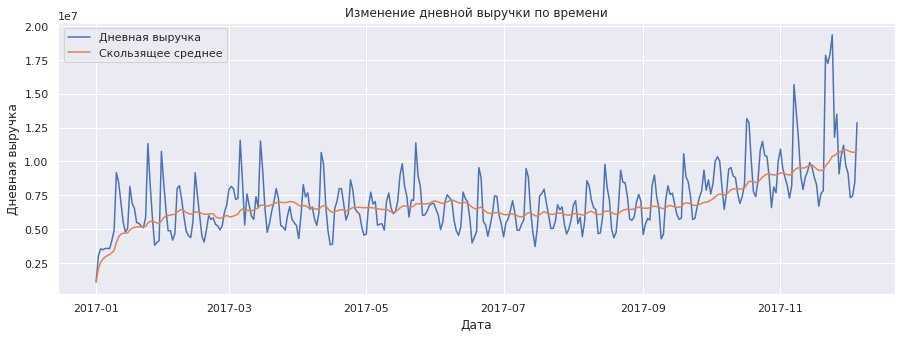

In [ ]:
sns.lineplot(data=rev_by_date, dashes=False)\
.set(title='Изменение дневной выручки по времени',
     xlabel='Дата',
     ylabel='Дневная выручка')
plt.legend(labels=['Дневная выручка', 'Скользящее среднее']);

График стал более наглядным и тенденция роста выручки в конце года стала заметнее.

### Изменение количества уникальных покупателей

Наконец, посмотрим, как меняется количество уникальных покупателей во времени.

In [ ]:
user_by_date = df.groupby('o_date').agg({'user_id': 'nunique'})

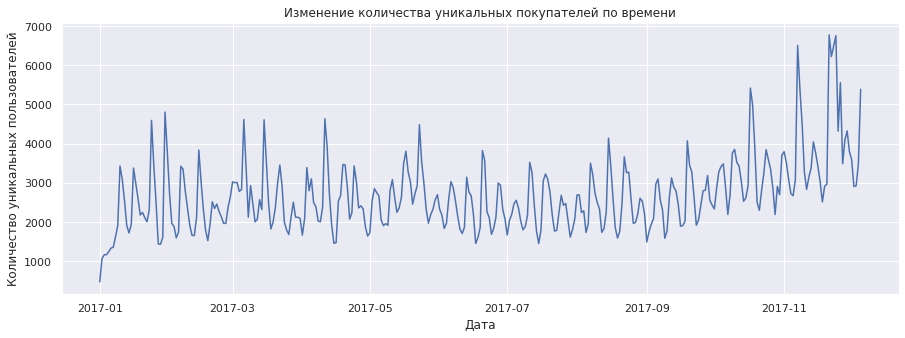

In [ ]:
sns.lineplot(data=user_by_date, legend=False)\
.set(title='Изменение количества уникальных покупателей по времени',
     xlabel='Дата',
     ylabel='Количество уникальных пользователей');

На графике количества уникальных пользователей мы наблюдаем схожие колебания. Возможно резкие изменения количества пользователей обсусловлены днями недели? Выясним это на следующих этапах анализа.

**Промежуточный вывод**

Мы построили графики изменения количества заказов, покупателей и выручки по времени. На всех трёх графиках заметна сильная волатильность.

## Месячные данные

Сформируем отдельные таблицы, в которых соберём данные по выручке, числу заказов и уникальных покупателей по месяцам.

Начнём с данных о количестве заказов.

In [ ]:
o_by_month = o_by_date.groupby(o_by_date.index.month).agg({'id_o': 'sum'})

In [ ]:
o_by_month.columns = ['o_qty']

In [ ]:
o_by_month.index = o_by_month.index.rename('month')

Таблица с количеством заказов по месяцам:

In [ ]:
o_by_month

,o_qty
month,
1,75966
2,70649
3,90347
4,85304
5,91946
6,77342
7,76998
8,84374
9,80971


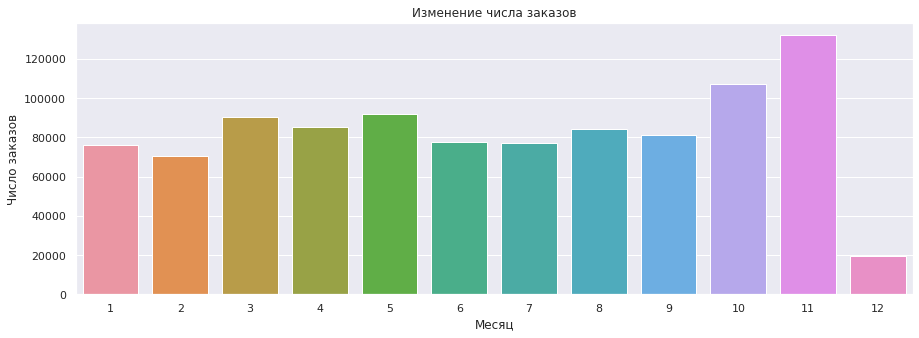

In [ ]:
sns.barplot(data=o_by_month, x=o_by_month.index, y='o_qty')\
.set(title='Изменение числа заказов',
     xlabel='Месяц',
     ylabel='Число заказов');

Построим аналогичную таблицу для месячной выручки.

In [ ]:
rev_by_month = rev_by_date.groupby(rev_by_date.index.month).agg({'price': 'sum'})

In [ ]:
rev_by_month.columns = ['revenue']

In [ ]:
rev_by_month.index = rev_by_month.index.rename('month')

Таблица с месячной выручкой:

In [ ]:
rev_by_month

,revenue
month,
1,176330569.1
2,161196190.4
3,214646804.4
4,197257227.3
5,216736893.1
6,184434501.3
7,186704442.4
8,205751825.3
9,211077971.3


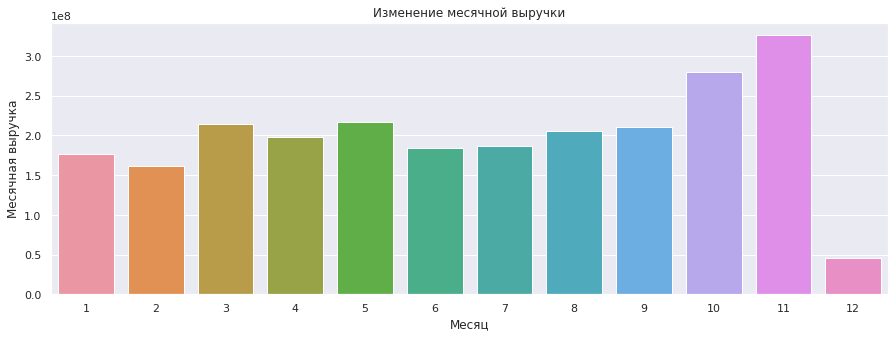

In [ ]:
sns.barplot(data=rev_by_month, x=rev_by_month.index, y='revenue')\
.set(title='Изменение месячной выручки',
     xlabel='Месяц',
     ylabel='Месячная выручка');

Наконец, посчитаем, какое количество уникальных покупателей делает заказы каждый месяц.

In [ ]:
user_by_month = df.groupby(df.o_date.dt.month).agg({'user_id': 'nunique'})

In [ ]:
user_by_month.columns = ['nunique_users']

In [ ]:
user_by_month.index = user_by_month.index.rename('month')

Таблица с количеством уникальных пользователей по месяцам.

In [ ]:
user_by_month

,nunique_users
month,
1,58407
2,55012
3,68011
4,63823
5,68668
6,59829
7,60252
8,66784
9,64761


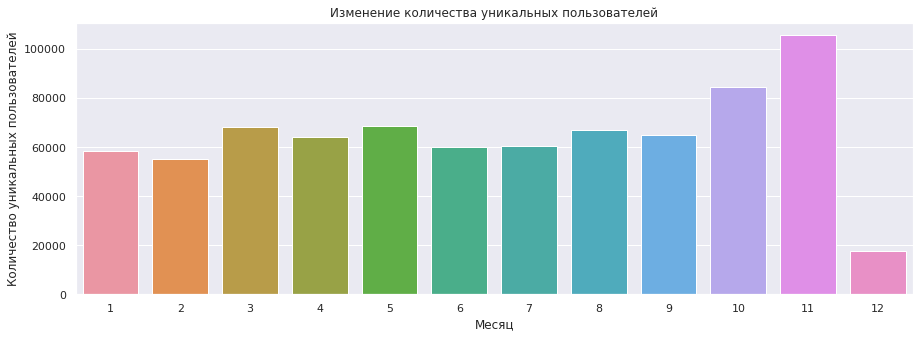

In [ ]:
sns.barplot(data=user_by_month, x=user_by_month.index, y='nunique_users')\
.set(title='Изменение количества уникальных пользователей',
     xlabel='Месяц',
     ylabel='Количество уникальных пользователей');

Наконец, сведём все месячные данные в одну таблицу.

In [ ]:
months = pd.merge(left=user_by_month, right=o_by_month, left_index=True, 
                  right_index=True)

In [ ]:
months = pd.merge(left=months, right=rev_by_month, left_index=True, 
                  right_index=True)

Сводная таблица

In [ ]:
months

,nunique_users,o_qty,revenue
month,,,
1,58407,75966,176330569.1
2,55012,70649,161196190.4
3,68011,90347,214646804.4
4,63823,85304,197257227.3
5,68668,91946,216736893.1
6,59829,77342,184434501.3
7,60252,76998,186704442.4
8,66784,84374,205751825.3
9,64761,80971,211077971.3


**Промежуточный вывод**

Сводная таблица получилась довольно интересной. В январе-феврале заказов и покупателей относительно мало, выручка тоже не высока. С марта по сентябрь количество уникальных покупателей, заказов и выручка изменяются от месяца к месяцу не очень сильно, а вот в октябре и ноябре наблюдается заметный рост. Данные за декабрь у нас не полные, поэтому делать выводы об этом месяце мы не можем.

## Разложение на тренд и сезонность

Выделим в данных по выручке тренд и сезонность.

In [ ]:
decomposed = seasonal_decompose(rev_by_date['price'])

In [ ]:
rev_by_date['trend'] = decomposed.trend

In [ ]:
rev_by_date = rev_by_date.drop('mean', axis=1)

Построим график выручки с добавлением линии тренда.

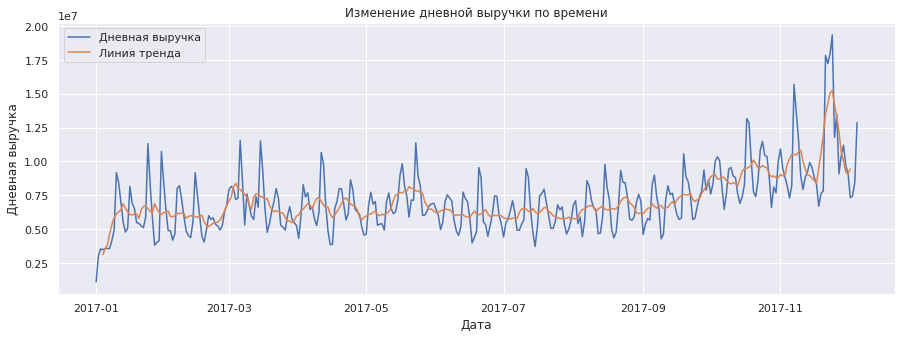

In [ ]:
sns.lineplot(data=rev_by_date, dashes=False)\
.set(title='Изменение дневной выручки по времени',
     xlabel='Дата',
     ylabel='Дневная выручка')
plt.legend(labels=['Дневная выручка', 'Линия тренда']);

Отдельно построим график сезонности за месяц и за неделю.

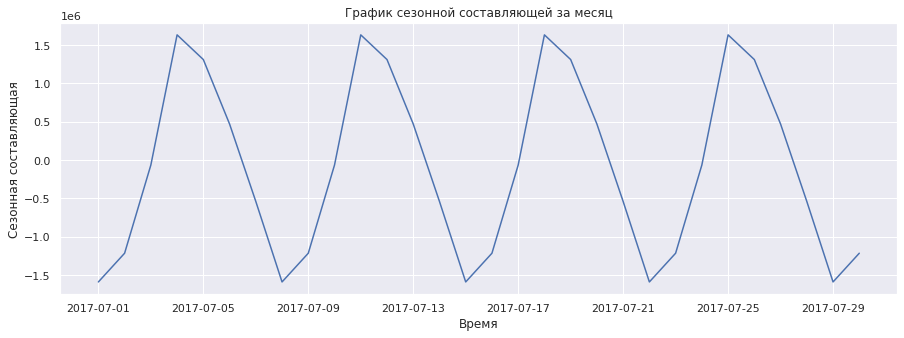

In [ ]:
sns.lineplot(data=decomposed.seasonal['2017-07-01':'2017-07-30'])\
.set(title='График сезонной составляющей за месяц',
     xlabel='Время',
     ylabel='Сезонная составляющая');

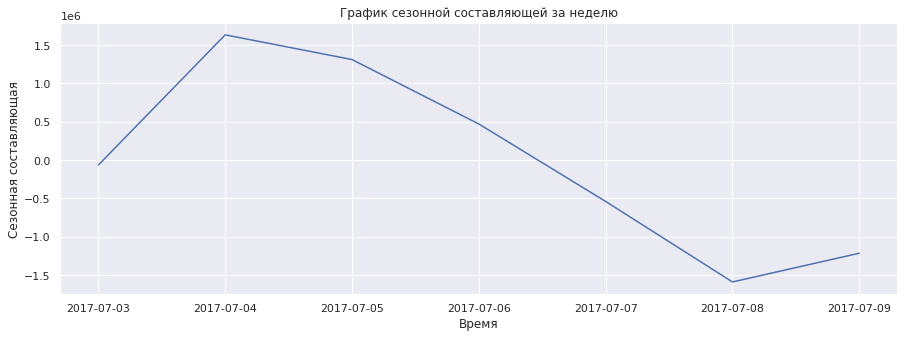

In [ ]:
sns.lineplot(data=decomposed.seasonal['2017-07-03':'2017-07-09'])\
.set(title='График сезонной составляющей за неделю',
     xlabel='Время',
     ylabel='Сезонная составляющая');

Похоже, что в наших данных налюдается недельная сезонность. Выручка растёт до вторника, затем снижается до субботы и снова начинает расти в воскресенье.



### Уравнение тренда и сезонность по месяцам

Рассчитаем уравнение тренда.

Прежде чем это делать вспомним, что данные за декабрь у нас не полные и могут сильно искажать тренд. Одним из вариантов решения данной проблемы может быть полное исключение данных за декабрь из расчёта, но в таком случае мы не сможем посчитать сезонность за этом месяц. Другим решением было бы "достроение" отсутствующих данных любым методом экстраполяции.

Посчитаем тренд и сезонность с учётом декабря но будем помнить, что это может занизить наши прогнозы.

In [ ]:
trend = np.polyfit(rev_by_month.index, rev_by_month['revenue'], 1)

Коэффициенты в уравнении тренда:

In [ ]:
print(np.poly1d(trend))

 
1.856e+06 x + 1.883e+08


Линия тренда восходящая, это радует. Нанесём её на график месячной выручки.

In [ ]:
rev_by_month['trend'] = trend[1] + trend[0] * rev_by_month.index

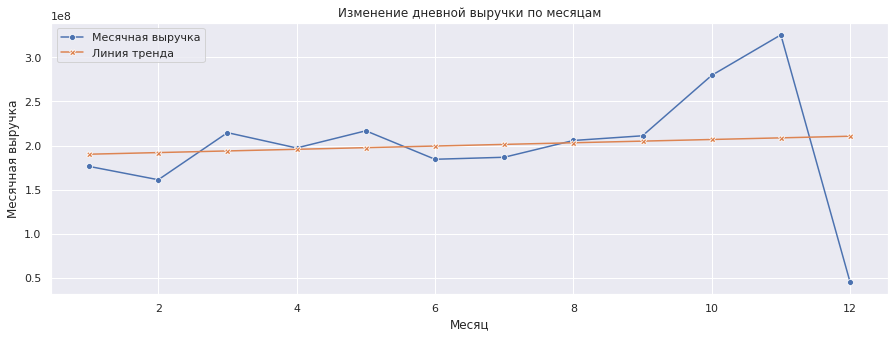

In [ ]:
sns.lineplot(data=rev_by_month[['revenue', 'trend']], 
             dashes=False, markers=True)\
.set(title='Изменение дневной выручки по месяцам',
     xlabel='Месяц',
     ylabel='Месячная выручка');
plt.legend(labels=['Месячная выручка', 'Линия тренда']);

Посчитаем сезонность по месяцам. Для этого фактические значения разделим на значения тренда.

In [ ]:
rev_by_month['coef'] = rev_by_month['revenue'] / rev_by_month['trend']

In [ ]:
rev_by_month

,revenue,trend,coef
month,,,
1,176330569.1,1.901746e+08,0.927204
2,161196190.4,1.920310e+08,0.839428
3,214646804.4,1.938874e+08,1.107070
4,197257227.3,1.957438e+08,1.007732
5,216736893.1,1.976002e+08,1.096846
6,184434501.3,1.994566e+08,0.924685
7,186704442.4,2.013130e+08,0.927434
8,205751825.3,2.031694e+08,1.012711
9,211077971.3,2.050258e+08,1.029519


Для декабря коэффициент получился очень малым, но следует помнить, что у нас нет полных данных за этот месяц, а на него приходится несколько праздников, что может стимулировать продажи.

## Прогнозирование выручки на 2018 год

Спрогнозируем выручку на 2018 год. Для этого продлим линию тренда и домножим получившиеся значения на месячные коэффициенты.

In [ ]:
forecast = pd.DataFrame(range(13, 25), columns=['month'])

In [ ]:
forecast['trend'] =  trend[1] + trend[0] * forecast.month

In [ ]:
forecast['forecast'] = forecast.trend *\
rev_by_month['coef'].reset_index(drop=True)

In [ ]:
forecast['month'] = forecast['month'] - 12

In [ ]:
forecast = forecast.set_index('month')

Построим график прогноза и тренда.

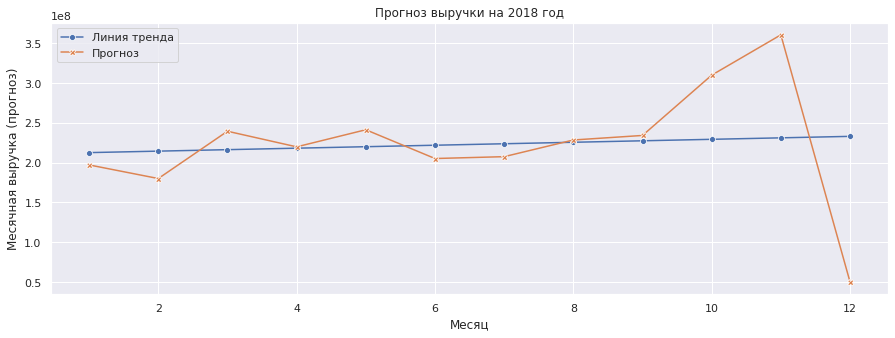

In [ ]:
sns.lineplot(data=forecast, dashes=False, markers=True)\
.set(title='Прогноз выручки на 2018 год',
     xlabel='Месяц',
     ylabel='Месячная выручка (прогноз)')
plt.legend(labels=['Линия тренда', 'Прогноз']);

Наш прогноз учитывает восходящий тренд 2017 года, на графике снова виден аналогичный "провал" выручки в декабре, связанный с отсутствием данных. Чтобы его избежать, можно было бы применить машинное обучение и "достроить" отсутсвующие данные.

## Факторы, влияющие на дневную выручку

Из вышеприведённого анализа и общих знаний экономики можно сделать вывод о том, какие факторы влияют на дневную выручку:


*   год и месяц (мы наблюдаем восходящий тренд по году и влияние сезонности по месяцам)
*   день недели (на графике недельной составляющей сезонности видно, что по вторникам выручка как правило выше, чем по субботам)
*   факт покупки определённых товаров (в наших данных есть записи об очень крупных покупках, которые будут значительно увелчивать дневную выручку)
*   день в году (по праздникам люди чаще покупают игрушки, например, в данных виден "скачок" выручки перед 8 марта)
*   проводимые акции и распродажи
*   проводимые рекламные компании
*   проводимые акции и распродажи
*   появление конкурентов
*   страновые, социальные и экологические факторы (например, пандемии и кризисы)
*   другие факторы, которые мы не можем предвидеть (в том числе и фактор случайности).


## Общий вывод по проекту

В рамках данного проекта мы проанализировали данные по продажам интернет-магазина игрушек.

В нашем распоряжении файл с миллионом записей. Пропусков данных нет, дубликатов данных нет. Описания данных у нас нет, но можно предположить, что в колонках хранится следующая информация:

*   `id_o` — идентификатор операции,
*   `user_id` — идентификатор пользователя,
*   `price` — цена (скорее всего в рублях),
*   `o_date` — дата совершения операции.

В рамках исследовательского анализа данных мы установили:

* в имеющихся данных содержатся записи о 500 тысячах уникальных пользователей
* Несколько пользователей совершили более 1000 покупок каждый (возможно это организации)
* Двадцать один пользователь совершил более 500 покупок каждый. 
* Большая часть пользователей (более 400 тысяч) совершали по одной покупке каждый
* В данных обнаружились записи с подозрительно высокой ценой, но мы их отфильтровали
* Средняя цена заказа - 2421 рубля
* Медианная - 1533 рубля
* Имеются данные о заказах с первого января 2017 года по седьмое декабря 2017 года

Мы также построили графики изменения количества заказов, покупателей и выручки по времени. На всех трёх графиках заметна сильная волатильность.

Мы построили сводную таблицу, в которой аккумулировали количество заказов, уникальных покупателей и выручку по месяцам. Сводная таблица получилась довольно интересной. В январе-феврале заказов и покупателей относительно мало, выручка тоже не высока. С марта по сентябрь количество уникальных покупателей, заказов и выручка изменяются от месяца к месяцу не очень сильно, а вот в октябре и ноябре наблюдается заметный рост. Данные за декабрь у нас не полные, поэтому делать выводы об этом месяце мы не можем. 

Затем на основе данной таблицы мы вычислили тренд и рассчитали месячную сезонность выручки. На построенных графиках наблюдается рост выручки в конце года.

На базе рассчитанных тренда и коэффициентов сезонности был сделан прогноз на 2018 год.

Также мы отобрали следующие факторы, влияющие на дневные продажи:

*   год и месяц (мы наблюдаем восходящий тренд по году и влияние сезонности по месяцам)
*   день недели (на графике недельной составляющей сезонности видно, что по вторникам выручка как правило выше, чем по субботам)
*   факт покупки определённых товаров (в наших данных есть записи об очень крупных покупках, которые будут значительно увелчивать дневную выручку)
*   день в году (по праздникам люди чаще покупают игрушки, например, в данных виден "скачок" выручки перед 8 марта)
*   проводимые акции и распродажи
*   проводимые рекламные компании
*   проводимые акции и распродажи
*   появление конкурентов
*   страновые, социальные и экологические факторы (например, пандемии и кризисы)
*   другие факторы, которые мы не можем предвидеть (в том числе и фактор случайности).